<a href="https://colab.research.google.com/github/Waye/CSC420-CourseWork-fall2019/blob/master/Tutorial/csc420_tut2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Helper code
You can ignore the restart warning.

In [0]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install numpy
!pip install Pillow==4.0.0

     |████████████████████████████████| 5.6MB 2.6MB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.0+cu100 which is incompatible.
ERROR: scikit-image 0.14.3 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
!rm -rf csc420-tutorial
!git clone https://github.com/sajadn/csc420-tutorial


Cloning into 'csc420-tutorial'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 46 (delta 16), reused 43 (delta 13), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [0]:
%run csc420-tutorial/helper.py

## Download files

This may take 1 or 2 mins for the first time.

In [0]:
######################################################################
# Download CIFAR datasets and other related files
######################################################################
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~sajadn/kmeans_colour_tut2.tar.gz', 
                         untar=True)
m = load_cifar10()

data/colours.tar.gz
Extracting file.
data/cifar-10-batches-py.tar.gz
Extracting file.


## Training

In [0]:

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True, downsize_input=False):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                           test_rgb_cat,
                                           batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath:  # only plot if a path is provided
        plot(xs, ys, predicted.cpu().numpy(), colours,
             plotpath, visualize=visualize, compare_bilinear=downsize_input)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc


def train(args, cnn=None):
  
    #SOME SET UPS
    np_load_old = copy_func(np.load)
    np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)
    
    torch.set_num_threads(5)
    npr.seed(args.seed)
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours)[0]
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1
    # LOAD THE MODEL
    if cnn is None:
      if args.model == "CNN":
          cnn = CNN(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNet":
          cnn = UNet(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu: cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb_cat,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot(xs, ys, predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
            epoch+1, args.epochs, avg_loss, time_elapsed))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(cnn,
                                                criterion,
                                                test_grey,
                                                test_rgb_cat,
                                                args.batch_size,
                                                colours,
                                                save_dir+'/test_%d.png' % epoch,
                                                args.visualize,
                                                args.downsize_input)

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %d' % (
            epoch+1, args.epochs, val_loss, val_acc, time_elapsed))
    

    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    np.load = np_load_old
    return cnn

## Convolutional Autoencoder


In [0]:

class CNN(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN, self).__init__()
        padding = kernel // 2
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3, num_colours, kernel_size=kernel, padding=padding)
        


    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out4 = self.upconv1(self.out3)
        self.out5 = self.upconv2(self.out4)
        self.out_final = self.finalconv(self.out5)
        return self.out_final

## Main training loop for CNN




Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Epoch [1/25], Loss: 2.9182, Time (s): 1
Epoch [1/25], Val Loss: 2.7582, Val Acc: 16.7%, Time(s): 2
Epoch [2/25], Loss: 2.5861, Time (s): 3
Epoch [2/25], Val Loss: 2.4700, Val Acc: 20.2%, Time(s): 3
Epoch [3/25], Loss: 2.4067, Time (s): 5
Epoch [3/25], Val Loss: 2.3296, Val Acc: 22.6%, Time(s): 5
Epoch [4/25], Loss: 2.2915, Time (s): 7
Epoch [4/25], Val Loss: 2.2319, Val Acc: 24.8%, Time(s): 7
Epoch [5/25], Loss: 2.2022, Time (s): 9
Epoch [5/25], Val Loss: 2.1593, Val Acc: 27.4%, Time(s): 9
Epoch [6/25], Loss: 2.1247, Time (s): 11
Epoch [6/25], Val Loss: 2.0870, Val Acc: 29.0%, Time(s): 11
Epoch [7/25], Loss: 2.0608, Time (s): 13
Epoch [7/25], Val Loss: 2.0339, Val Acc: 30.1%, Time(s): 13
Epoch [8/25], Loss: 2.0102, Time (s): 15
Epoch [8/25], Val Loss: 1.9912, Val Acc: 30.8%, Time(s): 15
Epoch [9/25], Loss: 1.9696, Time (s): 17
Epoch [9/25], Val Loss: 1.9564, Val Acc: 31.3%, Time(s): 17
Epoch [10/25], Loss: 1.9366, Time (s): 19
Epoch [10/25], Val Loss: 1.9218, Val Acc: 31.9%, Time(s): 1

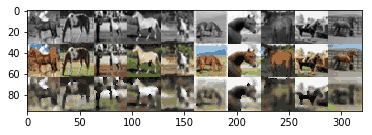

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

## UNet


In [0]:
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet, self).__init__()
        padding = kernel // 2
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters*2, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.finalconv = nn.Conv2d(num_in_channels+3, num_colours, kernel_size=kernel, padding=padding)
        
    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out4 = self.upconv1(torch.cat((self.out3, self.out2), dim = 1))
        self.out5 = self.upconv2(torch.cat((self.out4, self.out1), dim = 1))
        self.out_final = self.finalconv(torch.cat((self.out5, x), dim = 1))
        return self.out_final

##Main training loop for Unet

Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.9274, Time (s): 2
Epoch [1/25], Val Loss: 2.7349, Val Acc: 16.2%, Time(s): 2
Epoch [2/25], Loss: 2.6079, Time (s): 3
Epoch [2/25], Val Loss: 2.4917, Val Acc: 20.0%, Time(s): 4
Epoch [3/25], Loss: 2.4268, Time (s): 5
Epoch [3/25], Val Loss: 2.3478, Val Acc: 23.1%, Time(s): 6
Epoch [4/25], Loss: 2.2986, Time (s): 7
Epoch [4/25], Val Loss: 2.2303, Val Acc: 27.1%, Time(s): 8
Epoch [5/25], Loss: 2.1971, Time (s): 9
Epoch [5/25], Val Loss: 2.1287, Val Acc: 29.5%, Time(s): 10
Epoch [6/25], Loss: 2.1055, Time (s): 11
Epoch [6/25], Val Loss: 2.0492, Val Acc: 31.4%, Time(s): 12
Epoch [7/25], Loss: 2.0164, Time (s): 13
Epoch [7/25], Val Loss: 1.9460, Val Acc: 32.9%, Time(s): 14
Epoch [8/25], Loss: 1.9363, Time (s): 15
Epoch [8/25], Val Loss: 1.8838, Val Acc: 34.7%, Time(s): 16
Epoch [9/25], Loss: 1.8789, Time (s): 17
Epoch [9/25], Val Loss: 1.8499, Val Acc: 35.7%, Time(s): 18
Epoch [1

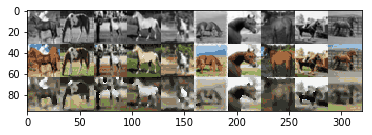

In [0]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
               'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)